In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense, Reshape
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl
import pickle
from IPython.display import clear_output
mnist = pickle.load(open('mnist.pkl','rb'))

x_train, y_train = Tensor(mnist['training_images'].reshape(-1,100,28,28)/255), Tensor(np.array([[0]*i+[1]+[0]*(9-i) for i in mnist['training_labels']]))

model = NeuralNetwork([Conv((14,14),3,0,(1,1),sigmoid,inputShape=(28,28,1)),Conv((10,10),9,0,(1,1),sigmoid), Reshape(-1), Dense(10, sigmoid)])
def plotfunc(loss):
    if len(loss) % 50 == 0:
        plt.plot(loss[50:])
        plt.pause(0.1)
        clear_output(wait=True)

model.train(x_train, y_train, epochs=50, lrate=0.01, plotfunc=plotfunc)

KeyboardInterrupt: 

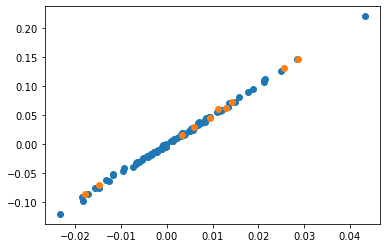

In [5]:
import numpy as np
from NeuralNetwork import NeuralNetwork, sigmoid
from Dense import Dense, Reshape
from Conv import Conv
from Tensor import Tensor
import matplotlib.pyplot as plt
import pyopencl as cl

model = NeuralNetwork([Conv((3,3),10,0,(1,1),sigmoid, inputShape=(6,6,1)),Conv((3,3),3,0,(1,1),sigmoid),Reshape(-1),Dense(10,sigmoid)])
model.allocateMemory(1)
x = Tensor(np.random.randn(*(1,*model.inputShape)))
y = Tensor(np.random.randn(1,*model.outputShape))
model.gradientDescent(x,y,0)
dw,db = model.testGrads(x,y)

l = 0
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())

In [5]:
l = 3
plt.scatter(dw[l],model.layers[l].dw.get().flatten())
plt.scatter(db[l],model.layers[l].db.get().flatten())

NameError: name 'plt' is not defined

In [4]:
from tests import *
from testsConv import *

batchSize = 10
conv = Conv((3,3),10,0,(1,1),sigmoid, inputShape=(6,6,1))
conv.allocateMemory(batchSize)
ym1 = Tensor(np.random.randn(batchSize,*conv.inputShape))
sigmaOut = Tensor(np.random.randn(batchSize,*conv.outputShape))
Y =  Tensor(np.random.randn(batchSize,*conv.outputShape))
e = Tensor(np.zeros((batchSize,*conv.outputShape)))


test(conv.GPUForwardPropagate,forwardPropagate,(ym1,))
test(conv.activate,sigmoidTest,tuple())
test(conv.computeError,computeError,(Y,e))
test(conv.computedb,computedb,(e,))
test(conv.computeGradients,computeGradients,(ym1,e))
test(conv.computeLocalGradient,computeLocalGradient,(sigmaOut,))
test(conv.learningRule,learningRule,(np.float32(0.1),))


Test Passed forwardPropagate
Test Passed sigmoidTest
Test Passed computeError
Test Passed computedb
Test Passed computeGradients
Test Passed computeLocalGradient
Test Passed learningRule


{}

In [2]:
from tests import *
from testsConv import *

batchSize = 10
conv = Conv((3,3),10,0,(1,1),sigmoid, inputShape=(6,6,1))
conv.allocateMemory(batchSize)
ym1 = Tensor(np.random.randn(batchSize,*conv.inputShape))
sigmaOut = Tensor(np.random.randn(batchSize,*conv.outputShape))
Y =  Tensor(np.random.randn(batchSize,*conv.outputShape))
e = Tensor(np.zeros((batchSize,*conv.outputShape)))



conv.computeLocalGradient(sigmaOut)
#conv.forwardPropagate(ym1)
#conv.backwardPropagate(sigma = sigmaOut,lrate = 0)
1

RuntimeError: clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE - clBuildProgram failed: BUILD_PROGRAM_FAILURE

Build on <pyopencl.Device 'AMD Radeon R9 M380 Compute Engine' on 'Apple' at 0x1021c00>:

<program source>:182:21: error: indirection requires pointer operand ('float' invalid)
                    *w[ out3      *kernel1*kernel2*inSize3 +
                    ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

(options: -I /opt/anaconda3/lib/python3.8/site-packages/pyopencl/cl)
(source saved as /var/folders/8n/_7860n3x44gfg2xfqmjh0d0w0000gn/T/tmprgmxd0io.cl)

In [4]:
#test(conv.computeLocalGradient,computeLocalGradient2,(sigmaOut,))

params = test(conv.computeLocalGradient,computeLocalGradient,(sigmaOut,))

Test Failed computeLocalGradient
Param Index 11 with name "sigmaIn" was off by 0.5071778297424316



In [26]:
batch = 5
(params['sigmaIn'][0][batch,:,:,0]-params['sigmaIn'][1][batch,:,:,0]).round(2)

array([[ 0.  ,  0.  , -0.08,  0.09,  0.  ,  0.  ],
       [ 0.27, -0.37, -0.05, -0.05, -0.2 ,  0.03],
       [ 0.08,  0.12, -0.41,  0.95, -0.04,  0.01],
       [ 0.32,  0.23,  0.42, -0.54, -0.4 ,  0.16],
       [ 0.03,  0.34, -0.34,  0.49,  0.01,  0.  ],
       [ 0.  ,  0.17,  0.43,  0.79, -0.18,  0.14]], dtype=float32)

In [3]:
from tests import parse
kernelFuncion = """
kernel void computeLocalGradient(global float *sigmaOut,
                            const uint outSize1,
                            const uint outSize2,
                            const uint filters,
                            const uint inSize1,
                            const uint inSize2,
                            const uint inSize3,
                            const uint kernel1,
                            const uint kernel2,
                            const uint stride1,
                            const uint stride2,
                            global float *sigmaIn,
                            global float *dphi,
                            global float *w){
                                
    uint batch = get_global_id(0)/filters;
    uint in1 = get_global_id(1)/inSize2;
    uint in2 = get_global_id(1)%inSize2;
    uint in3 = get_global_id(2);
  
    uint indIn = batch               *inSize3*inSize2*inSize1 + 
                 in1                  *inSize3*inSize2 + 
                 in2                  *inSize3+
                 in3;  

    uint out1 = in1*stride1;
    uint out2 = in2*stride2;

    uint indOut = batch         *filters*outSize2*outSize1;
    uint indOut2;

    sigmaIn[indIn] = 0;

    uint end1 = min(kernel1,out1+1);
    uint end2 = min(kernel2,out2+1);
    for(uint k1 = max(inSize1,kernel1+in1)-inSize1; k1<end1; k1+=stride1){
        for(uint k2 = max(inSize2,kernel2+in2)-inSize2; k2<end2; k2+=stride2){
            for(uint out3 = 0; out3<filters; out3++){
                indOut2 =
                (out1-k1)    *filters*outSize2 + 
                (out2-k2)    *filters + 
                out3;
                sigmaIn[indIn] +=
                    w[ out3      *kernel1*kernel2*inSize3 +
                        k1          *kernel2*inSize3 +
                        k2          *inSize3 +
                        in3]
                    *sigmaOut[indOut+indOut2]*dphi[indOut+indOut2];
            }                
        }
    }
}
"""
print(parse(kernelFuncion))


def computeLocalGradient( *sigmaOut,
                              outSize1,
                              outSize2,
                              filters,
                              inSize1,
                              inSize2,
                              inSize3,
                              kernel1,
                              kernel2,
                              stride1,
                              stride2,
                             *sigmaIn,
                             *dphi,
                             *w):
                                
     batch = globalIndex(0)/filters
     in1 = globalIndex(1)/inSize2
     in2 = globalIndex(1)%inSize2
     in3 = globalIndex(2)
  
     indIn = batch               *inSize3*inSize2*inSize1 + 
                 in1                  *inSize3*inSize2 + 
                 in2                  *inSize3+
                 in3  

     out1 = in1*stride1
     out2 = in2*stride2

     indOut = batch         *filters*outSize2*outSize1


In [3]:
kernelFuncion.replace('kernel void','def')

'\ndef sigmoid(global float *v,\n                    global float *y, global float *dphi){\n \n    uint ind = get_global_id(0);\n    if (v[ind] > 80){\n        v[ind] = 80;\n    }\n    if (v[ind] < -80){\n        v[ind] = -80;\n    }\n    y[ind] = 1/( 1 + exp(-v[ind]) );\n    dphi[ind] = y[ind]*(1-y[ind]);\n}\n'